# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from joblib import dump, load

# importing models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# importing metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
model_directory = "./models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Exploring data

In [3]:
sample_output = pd.read_csv("AI_CURE_PARSEC/sample_output_generated.csv")
sample_test = pd.read_csv("AI_CURE_PARSEC/sample_test_data.csv")
train_data = pd.read_csv("AI_CURE_PARSEC/train_data.csv")

In [4]:
train_data.tail(2)

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,...,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR
4998,afaecca1-7686-4a3e-9d96-59357bcb29a8,1436.829269,78.868209,378.173100,20.758093,98.231585,6.808066,0.373698,1.768415,1821.810435,...,-0.311388,0.011621,0.000065,-0.000103,0.011439,0.005135,0.005135,2.227645,-0.311388,0.011621
4999,10342ad1-fa6f-42de-b9ca-28c0ae1e8f4d,948.733194,25.972073,2559.461263,70.066605,94.648881,144.703039,3.961322,5.351119,3652.897496,...,-0.154123,0.337514,0.000106,-0.003580,0.031879,0.017732,0.017732,1.797847,-0.154123,0.337514


In [5]:
sample_output.tail(2)

,uuid,HR
8,94364ef1-12e2-4ddd-9f35-99e270547849,56.271876
9,231d34f5-1028-4f2e-8e1d-00d086b0c218,71.201501


In [6]:
sample_test.tail(2)

,uuid,VLF,VLF_PCT,LF,LF_PCT,LF_NU,HF,HF_PCT,HF_NU,TP,...,KURT,SKEW,MEAN_REL_RR,MEDIAN_REL_RR,SDRR_REL_RR,RMSSD_REL_RR,SDSD_REL_RR,SDRR_RMSSD_REL_RR,KURT_REL_RR,SKEW_REL_RR
8,94364ef1-12e2-4ddd-9f35-99e270547849,5398.507844,86.726313,817.994855,13.140979,99.000217,8.260761,0.132708,0.999783,6224.763460,...,-1.051725,0.170944,-0.000218,-0.000510,0.020239,0.007790,0.007790,2.598129,-1.051725,0.170944
9,231d34f5-1028-4f2e-8e1d-00d086b0c218,1426.583119,73.937431,482.489601,25.006634,95.948462,20.373698,1.055935,4.051538,1929.446418,...,-0.060943,-0.676414,0.000072,0.000305,0.013778,0.007528,0.007528,1.830086,-0.060943,-0.676414


# Pre-Processing

In [7]:
def pre_process_train(data):

  oh_encoder = OneHotEncoder(sparse_output = False)
  std_scaler = StandardScaler()

  data = data.drop(['datasetId'], axis = 1)
  condition_col = data.pop('condition')
  uuid_col = data.pop('uuid')
  labels = data.pop('HR')

  columns = data.columns
  scaled_data = std_scaler.fit_transform(data.to_numpy())
  scaled_data = pd.DataFrame(scaled_data, columns = columns)

  condition_col = np.array(condition_col.values).reshape(-1, 1)
  enc_col = oh_encoder.fit_transform(condition_col)
  scaled_data["is_interruption"] = enc_col[:, 0]
  scaled_data["is_no_stress"] = enc_col[:, 1]
  scaled_data["is_time_pressure"] = enc_col[:, 2]

  scaled_data["HR"] = labels.values

  # saving encoders
  dump(oh_encoder, 'models/oh_encoder.bin', compress=True)
  dump(std_scaler, 'models/std_scaler.bin', compress=True)

  return scaled_data

In [9]:
preprocessed_data = pre_process_train(train_data)
train_feat, train_labels = preprocessed_data.drop(['HR'], axis = 1), preprocessed_data['HR']

# Visualization

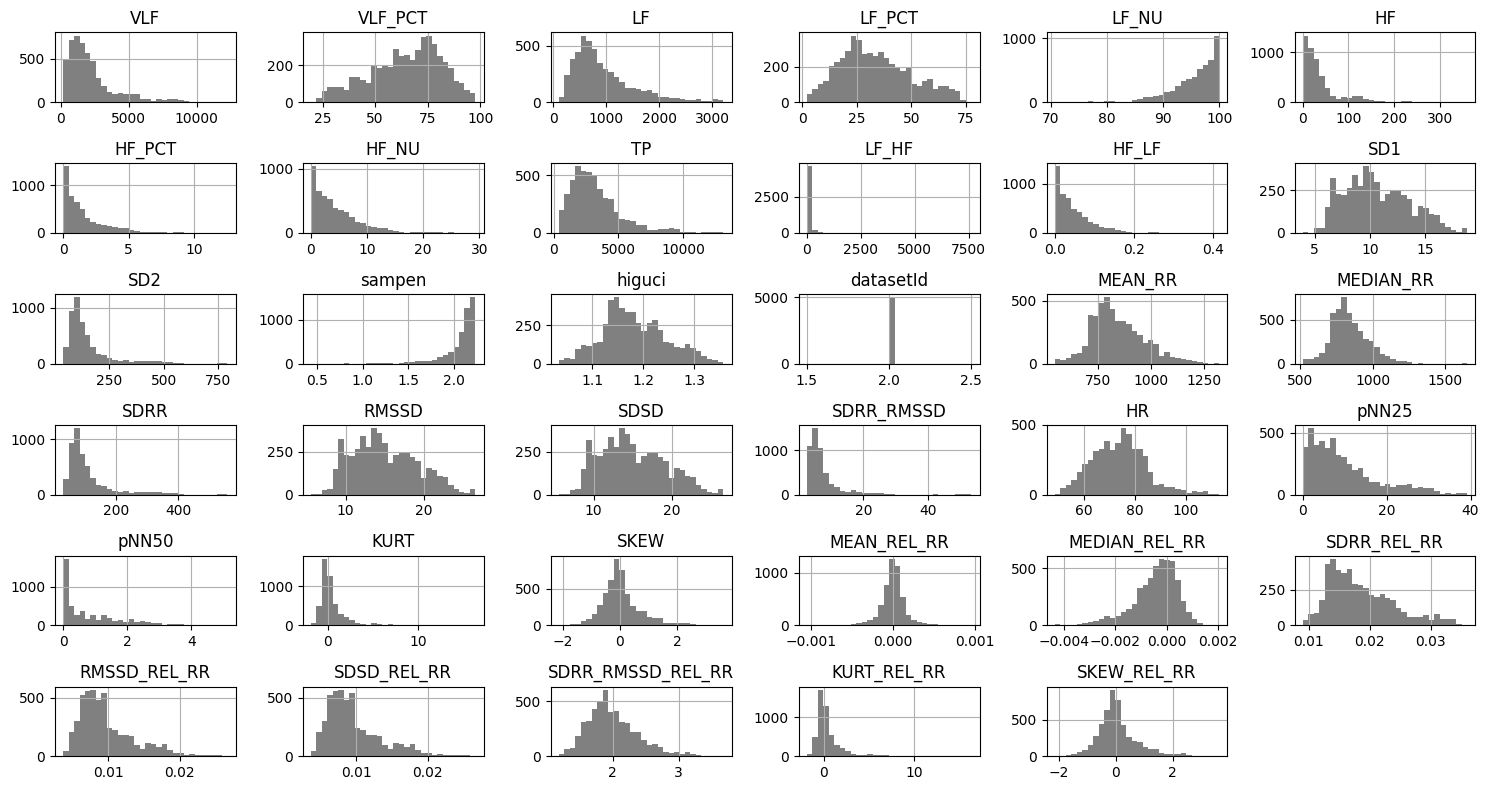

In [10]:
train_data.hist(bins=30 , figsize=(15,8), color = 'grey')
plt.tight_layout()
plt.show()

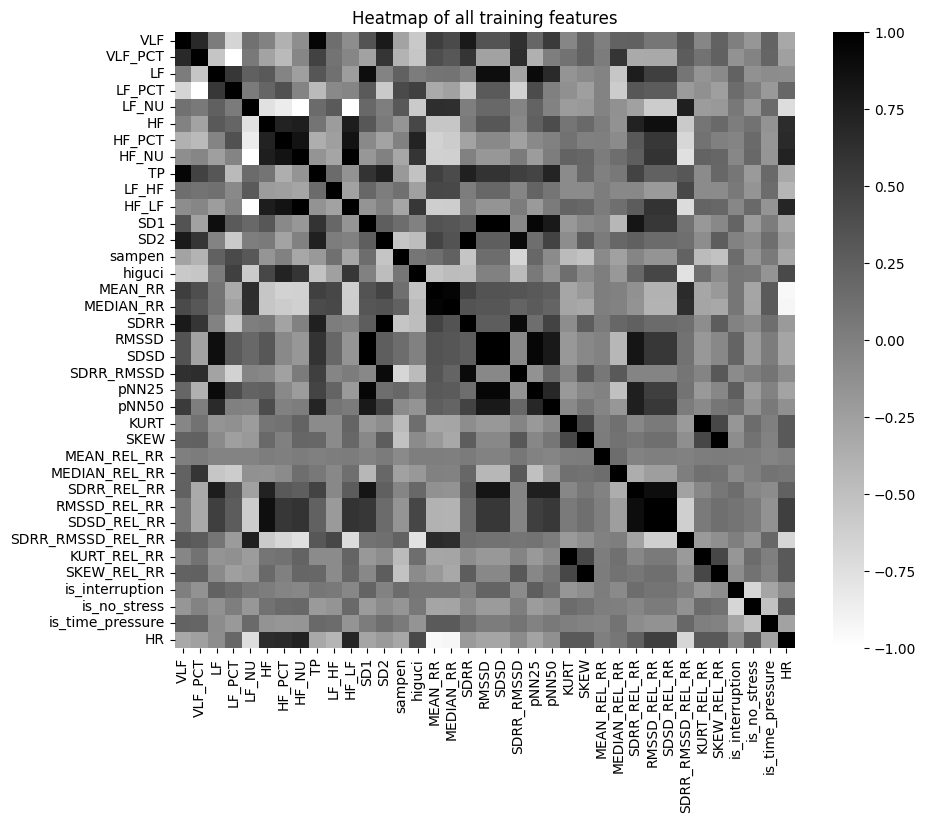

In [11]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(preprocessed_data.corr(), fmt=".2f", cmap='binary').set(title = "Heatmap of all training features")

# Feature Extraction
We see many correlated features above

In [12]:
# Checking highly Correlated features

corr_matrix = train_feat.corr()
high_corr_pairs = []
threshold = 0.9

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
print('High correlation between : ')
for pair in high_corr_pairs:
    print(f" {pair[0]} and {pair[1]}: {pair[2]}")


High correlation between : 
 LF_PCT and VLF_PCT: -0.9950806511552788
 HF_NU and LF_NU: -1.0
 TP and VLF: 0.9538044292018634
 HF_LF and LF_NU: -0.9960069349356272
 HF_LF and HF_NU: 0.996006934935628
 MEDIAN_RR and MEAN_RR: 0.9617247482068338
 SDRR and SD2: 0.9999972733217686
 RMSSD and SD1: 0.9999998239924506
 SDSD and SD1: 0.9999999999999998
 SDSD and RMSSD: 0.9999998239924507
 SDRR_RMSSD and SD2: 0.9171362986084796
 SDRR_RMSSD and SDRR: 0.9166059343106113
 pNN25 and LF: 0.915652695333169
 pNN25 and SD1: 0.9518294204204469
 pNN25 and RMSSD: 0.9518052506018987
 pNN25 and SDSD: 0.951829420420447
 SDSD_REL_RR and RMSSD_REL_RR: 0.9999999999468622
 KURT_REL_RR and KURT: 1.0
 SKEW_REL_RR and SKEW: 1.0


Based on above output and correlation heatmap, we will perform the following transformations (if required)

<table>
<tr>
  <th>SNo.</th>
  <th>Features</th>
  <th>Method</th>
  <th>New Feature</th>
</tr>

<tr>
  <td>1</td>
  <td>LF_PCT and VLF_PCT</td>
  <td>avg</td>
  <td>AVG1</td>
</tr>

<tr>
  <td>2</td>
  <td>TP and VLF</td>
  <td>avg</td>
  <td>AVG2</td>
</tr>

<tr>
  <td>3</td>
  <td>HF_LF and HF_NU</td>
  <td>avg</td>
  <td>AVG3</td>
</tr>

<tr>
  <td>4</td>
  <td>LF_NU</td>
  <td>remove</td>
  <td>-</td>
</tr>

<tr>
  <td>5</td>
  <td>MEAN_RR and MEDIAN_RR</td>
  <td>avg</td>
  <td>AVG4</td>
</tr>

<tr>
  <td>6</td>
  <td>KURT_REL_RR</td>
  <td>remove</td>
  <td>-</td>
</tr>

<tr>
  <td>7</td>
  <td>SKEW_REL_RR</td>
  <td>remove</td>
  <td>-</td>
</tr>

<tr>
  <td>8</td>
  <td>SDSD_REL_RR</td>
  <td>remove</td>
  <td>-</td>
</tr>

<tr>
  <td>9</td>
  <td>SDRR</td>
  <td>remove</td>
  <td>-</td>
</tr>

<tr>
  <td>10</td>
  <td>SDSD</td>
  <td>remove</td>
  <td>-</td>
</tr>

<tr>
  <td>11</td>
  <td>SD1</td>
  <td>remove</td>
  <td>-</td>
</tr>
</table>



In [13]:
# comments denote that the operation is not done because of increasing error

def extract_features(data):

  data['AVG2'] = data[['TP', 'VLF']].mean(axis=1)
  data['AVG3'] = data[['HF_LF', 'HF_NU']].mean(axis=1)
  # data['AVG1'] = data[['LF_PCT', 'VLF_PCT']].mean(axis=1)
  # data['AVG4'] = data[['MEAN_RR' ,'MEDIAN_RR']].mean(axis=1)

  data = data.drop([
      'KURT_REL_RR',
      'SKEW_REL_RR',
      'SDSD_REL_RR',
      'SDSD',
      'HF_LF',
      'HF_NU',
      # 'TP',
      # 'VLF',
      # 'LF_PCT' ,
      # 'VLF_PCT',
      # 'MEAN_RR',
      # 'MEDIAN_RR',
      # 'SDRR',
      # 'SD1'
  ], axis=1)

  return data
print("Total Features before extraction :", len(train_feat.columns))
train_feat = extract_features(train_feat)
print("Total Features after  extraction :", len(train_feat.columns))

Total Features before extraction : 36
Total Features after  extraction : 32


# Test Models

In [14]:
# training using 80% data
X_train, X_test, y_train, y_test = train_test_split(train_feat.values, train_labels.values, random_state = 42, train_size = 0.8)

model1 = LinearRegression()                               # 1.9260 - benchmark
model2 = RandomForestRegressor()                          # 0.1582 (may vary)
model3 = XGBRegressor()                                   # 0.1697
model4 = LGBMRegressor(force_col_wise=True,verbose = 0)   # 0.1093 - best

_ = model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('LinearRegression       MSE: {:.4f}'.format(mse))

_ = model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RandomForestRegressor  MSE: {:.4f}'.format(mse))

_ = model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('XGBRegressor           MSE: {:.4f}'.format(mse))

_ = model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('LGBMRegressor          MSE: {:.4f}'.format(mse))

LinearRegression       MSE: 1.9260


RandomForestRegressor  MSE: 0.1593
XGBRegressor           MSE: 0.1697
LGBMRegressor          MSE: 0.1093


In [15]:
# training with cv
X, y = train_feat.values, train_labels.values

model1 = LinearRegression()                                  # 2.2488 - benchmark
model2 = RandomForestRegressor()                             # 0.2095 (may vary)
model3 = XGBRegressor()                                      # 0.1964
model4 = LGBMRegressor(force_col_wise=True, verbose = 0)     # 0.1619 - BEST

scores = cross_val_score(model1, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse = -1 * scores.mean()
print('LinearRegression       Average MSE: {:.4f}'.format(average_mse))

scores = cross_val_score(model2, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse = -1 * scores.mean()
print('RandomForestRegressor  Average MSE: {:.4f}'.format(average_mse))

scores = cross_val_score(model3, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse = -1 * scores.mean()
print('XGBRegressor           Average MSE: {:.4f}'.format(average_mse))

scores = cross_val_score(model4, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse = -1 * scores.mean()
print('LGBMRegressor          Average MSE: {:.4f}'.format(average_mse))

LinearRegression       Average MSE: 2.2490
RandomForestRegressor  Average MSE: 0.2092
XGBRegressor           Average MSE: 0.1964
LGBMRegressor          Average MSE: 0.1619


In [16]:
model = LGBMRegressor(force_col_wise=True, verbose=-1)

param_distributions = {
    'num_leaves': randint(20, 100),
    'max_depth': randint(5, 50),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 500)
}

# Random search
random_search = RandomizedSearchCV(model, param_distributions, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X, y)

best_parameters = random_search.best_params_
print("Best Parameters:", best_parameters)
print("Best Score:", -1 * random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'learning_rate': 0.05958008171890075, 'max_depth': 29, 'n_estimators': 376, 'num_leaves': 28}
Best Score: 0.13096952812147114


In [17]:
# best_parameters = {'learning_rate': 0.05958008171890075, 'max_depth': 29, 'n_estimators': 376, 'num_leaves': 28}

model = LGBMRegressor(force_col_wise=True, verbose = 0, **best_parameters)     # 0.1310 - BEST
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse = -1 * scores.mean()
print('LGBMRegressor(random search) Average MSE: {:.4f}'.format(average_mse))

LGBMRegressor(random search) Average MSE: 0.1310


# FINAL MODEL

In [18]:
best_model = LGBMRegressor(
    force_col_wise=True,
    verbose = 0,
    **best_parameters
  )

best_model.fit(X, y)
dump(best_model, "models/model.bin")

['models/model.bin']